In [0]:
##Opening Data And saving

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

!ls '/content/drive/My Drive/4º Curso/DeepLearning/DeepLearningLabs/Lab5/data/'
myDrive = '/content/drive/My Drive/4º Curso/DeepLearning/DeepLearningLabs/Lab5/data/'
myRoot = '/content/drive/My Drive/4º Curso/DeepLearning/DeepLearningLabs/Lab5/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
AEMnist  CVAECK  GANCK	GANMnist  mnist  MNIST_DAE  samples


In [0]:
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
import os

%run /content/drive/My\ Drive/4º\ Curso/DeepLearning/DeepLearningLabs/Lab5/Datasets.py

from torch.nn import functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import torchvision.utils as vutils

device = "cuda" if torch.cuda.is_available else "device"

# directory to save results
dirTarget = myRoot+'results/DCAE/'
if not os.path.exists(dirTarget):
    os.mkdir(dirTarget)

    
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 64, 64)
    return x

img_size = 64


ZDIMS = 256
num_epochs = 100
batch_size = 4068
learning_rate = .001
nc = 3
internal_c = 32

img_transform = transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor()
])

dataset = MNIST(dataDir = myDrive+'/mnist/MNIST/processed/training.pt',transform=img_transform,is_noisy = True)
dataloader = torch.utils.data.DataLoader(dataset = dataset, batch_size = batch_size, shuffle = True)

print(len(dataset))

60000


<Figure size 432x288 with 0 Axes>

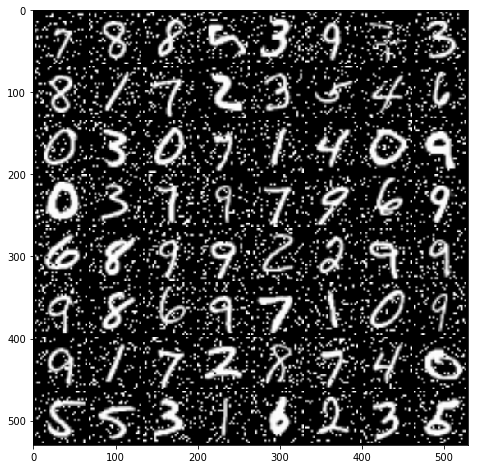

<Figure size 432x288 with 0 Axes>

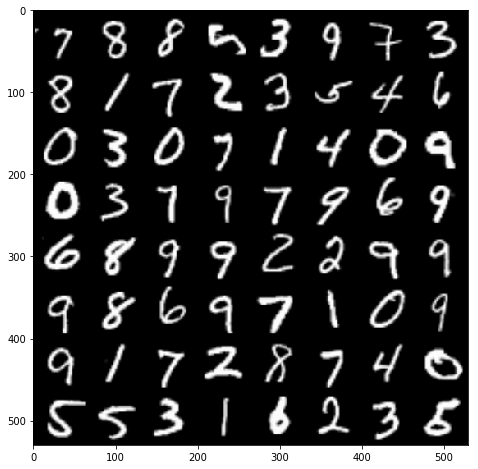

<Figure size 432x288 with 0 Axes>

In [0]:
from PIL import Image

img,_,img2 = next(iter(dataloader))
plt.figure(figsize=(int(sqrt(float(64))),int(sqrt(float(64)))))
plt.imshow(np.transpose(vutils.make_grid(img2[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.savefig(dirTarget+'noisy.jpg')
plt.show()
plt.gcf().clear()

plt.figure(figsize=(int(sqrt(float(64))),int(sqrt(float(64)))))
plt.imshow(np.transpose(vutils.make_grid(img[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.savefig(dirTarget+'ori.jpg')
plt.show()
plt.gcf().clear()


In [0]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(64 * 64, 256),
            nn.ReLU(True),
            nn.Linear(256, 64),
            nn.ReLU(True), nn.Linear(64, 12), nn.ReLU(True), nn.Linear(12, 3))
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 256),
            nn.ReLU(True), nn.Linear(256, 64 * 64), nn.Tanh())
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [0]:
model = autoencoder().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [0]:
import matplotlib.pyplot as plt

loss_list = []

for epoch in range(num_epochs):
    for data in dataloader:
        img,_,noisy = data
        # adapt sizes of img
        img = img.view(noisy.size(0), -1)
        img = Variable(img).cuda()
        #print(img.size())
        # adapt sizes of noisy
        noisy = noisy.view(noisy.size(0), -1)
        noisy = Variable(noisy).cuda()
        #print(noisy.size())
        # ===================forward=====================
        output = model(noisy)
        #print(output.size())
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # add loss to list
        loss_list.append(loss.item())
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss.item())) 
    

    if epoch % 10 == 0:
        # noisy
        noisy_img = to_img(noisy.cpu().data)
        imgName = dirTarget+'noisy_image_{}.png'.format(epoch)
        save_image(noisy_img, imgName)
        # target
        target_img = to_img(img.cpu().data)
        imgName = dirTarget+'targ_image_{}.png'.format(epoch)
        save_image(target_img, imgName)
        # predicted
        predicted = to_img(output.cpu().data)
        imgName = dirTarget+'pred_image_{}.png'.format(epoch)
        save_image(predicted, imgName)

epoch [1/100], loss:0.0635
epoch [2/100], loss:0.0573
epoch [3/100], loss:0.0554
epoch [4/100], loss:0.0531
epoch [5/100], loss:0.0516
epoch [6/100], loss:0.0488
epoch [7/100], loss:0.0465
epoch [8/100], loss:0.0457
epoch [9/100], loss:0.0446
epoch [10/100], loss:0.0442
epoch [11/100], loss:0.0437
epoch [12/100], loss:0.0433
epoch [13/100], loss:0.0417
epoch [14/100], loss:0.0400
epoch [15/100], loss:0.0392
epoch [16/100], loss:0.0373
epoch [17/100], loss:0.0365
epoch [18/100], loss:0.0368
epoch [19/100], loss:0.0360
epoch [20/100], loss:0.0359
epoch [21/100], loss:0.0347
epoch [22/100], loss:0.0341
epoch [23/100], loss:0.0348
epoch [24/100], loss:0.0340
epoch [25/100], loss:0.0332
epoch [26/100], loss:0.0334
epoch [27/100], loss:0.0324
epoch [28/100], loss:0.0328
epoch [29/100], loss:0.0324
epoch [30/100], loss:0.0323
epoch [31/100], loss:0.0321
epoch [32/100], loss:0.0317
epoch [33/100], loss:0.0317
epoch [34/100], loss:0.0312
epoch [35/100], loss:0.0307
epoch [36/100], loss:0.0309
e

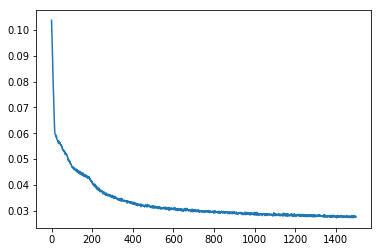

In [0]:
#plot of the loss during the training
plt.plot(loss_list)
plt.show()